In [1]:
#%pip install pybamm -q    # install PyBaMM if it is not installed
import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
from matplotlib import style
style.use('ggplot')
start = timeit.default_timer()
os.chdir(pybamm.__path__[0]+'/..')
pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.BasicDFN()
chemistry = pybamm.parameter_sets.Chen2020
param = pybamm.ParameterValues(chemistry=chemistry)
# model = pybamm.lithium_ion.DFN()
# param = model.default_parameter_values
param.update({"Upper voltage cut-off [V]": 4.5})
param.update({"Lower voltage cut-off [V]": 2})

# initial concentration of graphite 29866 [mol.m-3]
# -> 0.934 * 25830 + 0.0866 * 275220

C_rates = 0.01
Q_cell = 4.89 # [Ah]
period = 3600 / C_rates * Q_cell / 5
rest_period = 3600
rest_period2 = 3600
transition = period / 400
timestep=[rest_period, period, rest_period2, period]
points=[101,401,101,401]
t_evals=[]
t0 = 0
for i in range(0,len(timestep)):
    t1 = np.linspace(t0, t0 + timestep[i] - transition, points[i])
    t0 += timestep[i]
    if i<len(timestep)-1:
        t2 = np.linspace(t0 - transition, t0 + transition, 41) # transition points
    else:
        t2 = []
    t_evals=np.concatenate((t_evals, t1 ,t2))

t_evals = np.unique(t_evals)
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rates * capacity  

def I_fun(A):
    def current(t):
        C_rates = 0.01
        Q_cell = 4.89 # [Ah]
        period = 3600 / C_rates * Q_cell / 5
        rest_period = 3600
        rest_period2 = 3600
        k = 20
        rest = pybamm.sigmoid( t , rest_period, k)
        discharge = pybamm.sigmoid( t , rest_period + period, k) - rest
        # rest3 = pybamm.sigmoid( rest_period + period * 2 + rest_period2, t, k)
        charge = pybamm.sigmoid( rest_period + period + rest_period2, t, k)
        return A * discharge - A * charge
        # return A * (t < period) - A * (t >= period)
        # return A * 0.2 * pybamm.sin(2 * np.pi * t / 7200 )
    return current


param["Current function [A]"] = I_fun(I_load)

sim1 = pybamm.Simulation(
    model,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max = 10),
)
solution = sim1.solve(t_eval = t_evals)
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

2021-05-11 10:25:41,055 - [INFO] parameter_values.process_model(411): Start setting parameters for Doyle-Fuller-Newman model
2021-05-11 10:25:41,240 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-05-11 10:25:41,244 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-05-11 10:25:41,904 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-05-11 10:25:41,906 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-05-11 10:25:41,908 - [INFO] base_solver.set_up(140): Start solver set-up
2021-05-11 10:25:42,118 - [INFO] base_solver.set_up(426): Finish solver set-up
2021-05-11 10:26:27,419 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (the solver successfully reached the end of the integration interval)
2021-05-11 10:26:27,421 - [INFO] base_solver.solve(811): Set-up 

running time: 46.548471399990376s


In [3]:
# plot
plot = pybamm.QuickPlot( solution, [       
        "Current [A]",
        "Terminal voltage [V]",
        "X-averaged negative electrode open circuit potential [V]",
    ]
)
plot.dynamic_plot()


interactive(children=(FloatSlider(value=0.0, description='t', max=197.3555, step=1.9735550000000002), Output()…

In [4]:
current = solution["Current [A]"].entries
times = solution["Time [s]"].entries / 3600
voltage = solution["Terminal voltage [V]"].entries
ocp = solution["X-averaged negative electrode open circuit potential [V]"].entries
ocp_chen = pd.read_csv ("wip/data/negative_ocp_LGM50.txt", delimiter= '\s+',header=None,comment='#')
capacity = current * 0
capacity_max = 0
time_discharge = 0
Q_t = 0
for i in range(1,len(current)):
    Q_t += (current[i] + current[i - 1]) / 2 * (times[i] - times[i-1])
    capacity[i] = Q_t
capacity = Q_cell - capacity

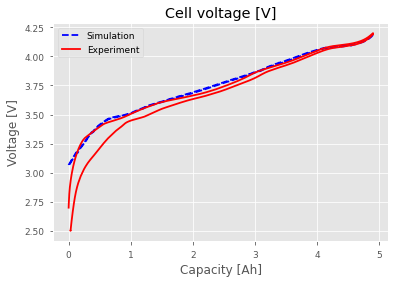

In [5]:
V1_Niall = pd.read_csv ("wip/data/NDK01_14_001C_1.txt", delimiter= '\s+',header=1,comment='#')
V2_Niall = pd.read_csv ("wip/data/NDK01_14_001C_2.txt", delimiter= '\s+',header=1,comment='#')
plt.plot(capacity,voltage,'b--',label='Simulation')
plt.plot(Q_cell - V2_Niall.values[:,4]/1000,V2_Niall.values[:,0],'r-',label='Experiment')
plt.plot(V1_Niall.values[:,4]/1000,V1_Niall.values[:,0],'r-',label=None)
plt.xlabel("Capacity [Ah]")
plt.ylabel("Voltage [V]")
plt.title("Cell voltage [V]")
plt.legend()

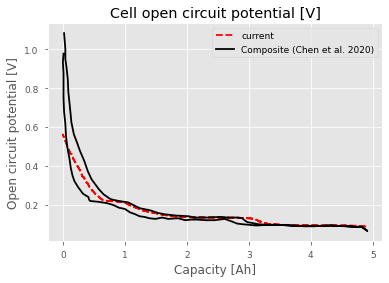

In [6]:
plt.plot(capacity,ocp,'r--',label='current')
plt.plot(ocp_chen.values[:,0],ocp_chen.values[:,1],'k-',label='Composite (Chen et al. 2020)')
plt.xlabel("Capacity [Ah]")
plt.ylabel("Open circuit potential [V]")
plt.title("Cell open circuit potential [V]")
plt.legend()

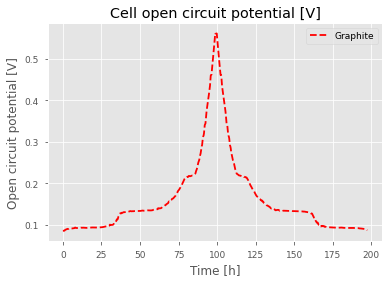

In [7]:
plt.plot(times,ocp,'r--',label='Graphite')
plt.xlabel("Time [h]")
plt.ylabel("Open circuit potential [V]")
plt.title("Cell open circuit potential [V]")
plt.legend()
# plt.xlim([100, 103])
# plt.ylim([0.4, 1])

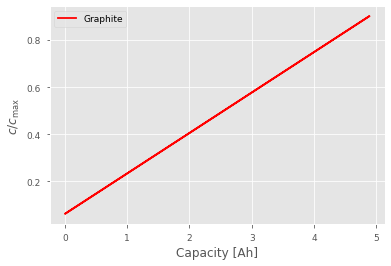

In [8]:
c_s_xrav_n = solution["Averaged negative electrode concentration"].entries
plt.plot(capacity, c_s_xrav_n,'r-', label='Graphite')
plt.xlabel("Capacity [Ah]")
plt.ylabel("$c/c_\mathrm{max}$")
# plt.ylim([0,0.02])
plt.legend()

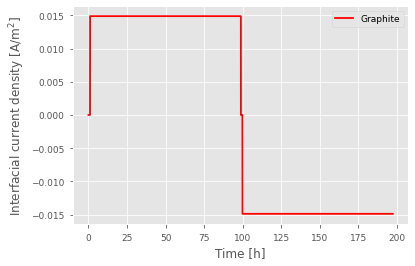

In [9]:
j_n_av = solution["X-averaged negative electrode interfacial current density [A.m-2]"].entries
plt.plot(times, j_n_av,'r-', label='Graphite')
plt.xlabel("Time [h]")
plt.ylabel("Interfacial current density [A/m$^{2}$]")
# plt.ylim([-0.2, 0.8])
# plt.xlim([96, 102])
plt.legend()

In [10]:
return

SyntaxError: 'return' outside function (<ipython-input-10-9b32c1431b19>, line 1)

In [ ]:
c_n_max= param["Maximum concentration in negative electrode [mol.m-3]"]
F = 96485.3329 #s A / mol
L_n =  param["Negative electrode thickness [m]"]
L_p =  param["Positive electrode thickness [m]"]
L_s =  param["Separator thickness [m]"]
I_typ = param["Typical current [A]"]
ne= param["Number of electrodes connected in parallel to make a cell"]
L_width = param["Electrode width [m]"]
L_height = param["Electrode height [m]"]
timescale = c_n_max * F * (L_p + L_n + L_s) / abs(I_typ / (ne * L_width * L_height))
print(timescale)

In [ ]:
print(min(c_s_xrav_n))

In [ ]:
print(range(0,len(timestep)))